In [4]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# SPECTER
from spectral_emd import compute_spectral_representation, cumulative_spectral_function
from spectral_emd import ds2


# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event




# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


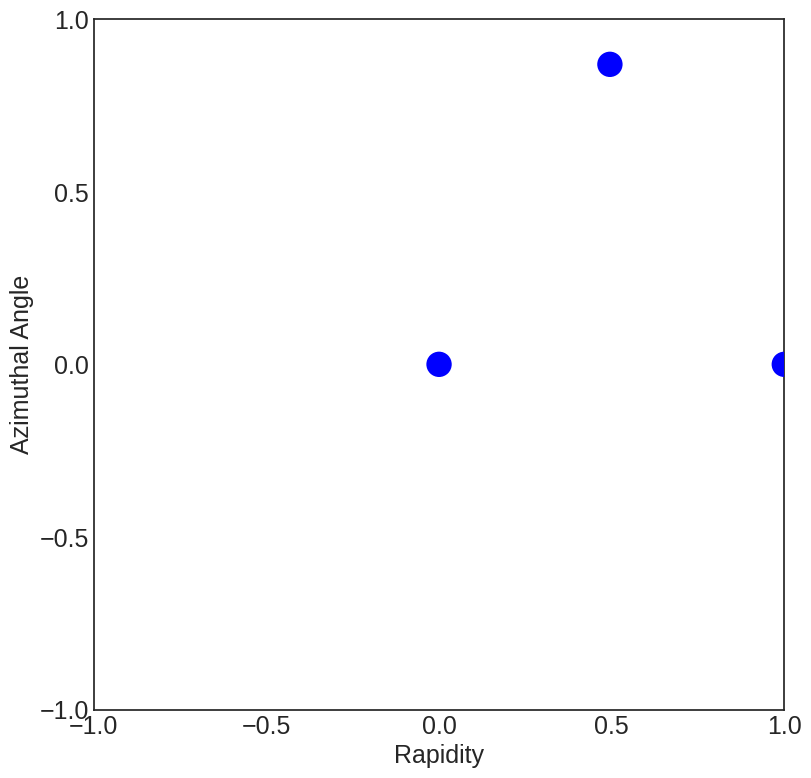

(0.0, 1.25)

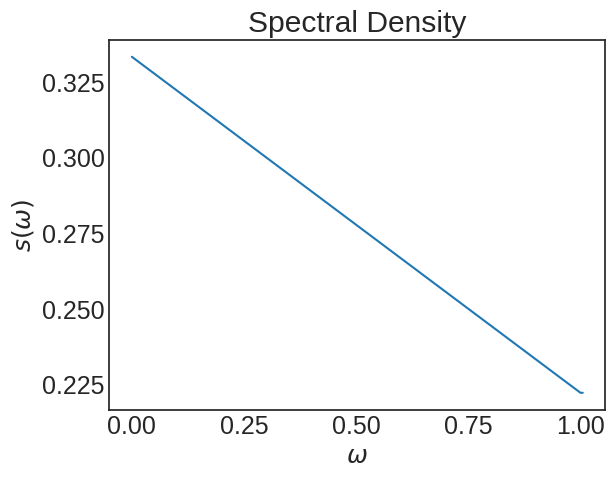

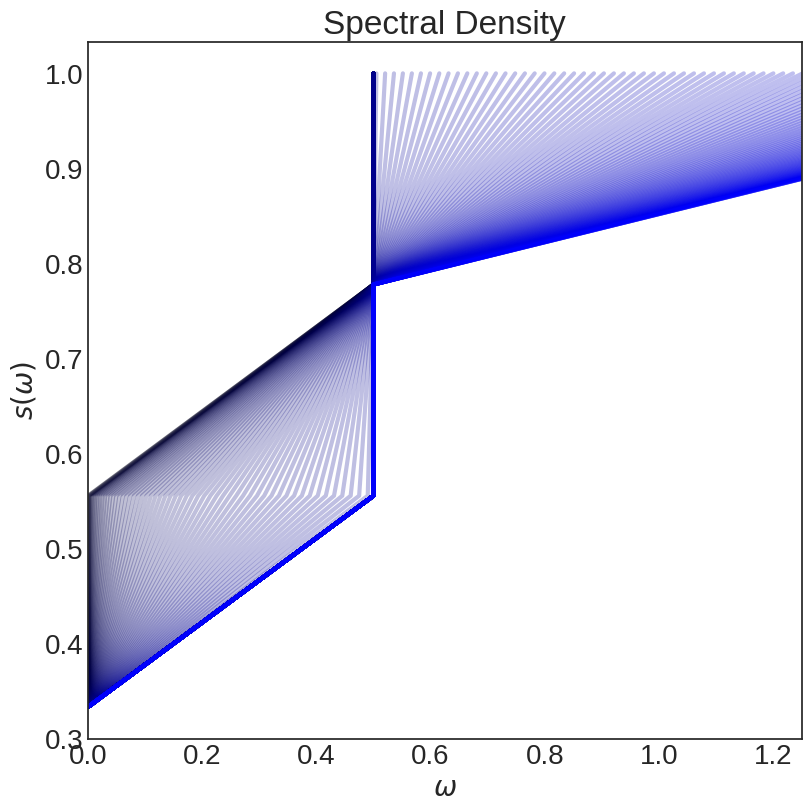

In [5]:
# Build 3 particle events
R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)

events = []
for i in range(N):

    zs = np.array([2.0/6.0, 2.0/6.0, 2.0/6.0])
    points = np.array([
                        (0.0, 0.0),
                        (R, 0.0),
                        (R*np.cos(angles[i]), R*np.sin(angles[i]))
              ])
    events.append((points, zs))

triangle_event = events[60]
plot_event(triangle_event[0], triangle_event[1], R, color = "blue")


s = compute_spectral_representation(triangle_event, type = "jet")
plt.plot(s[:,0], s[:,1])
# plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")


# Weird plot
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
for (i,event) in enumerate(events):
    s = compute_spectral_representation(event)
    S = cumulative_spectral_function(s)
    plt.plot(S[:,0], S[:,1], color = (0,0,np.sqrt(i/len(events))), alpha = 0.25, lw = 3)
# plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(0, 1.25)

(17, 13)


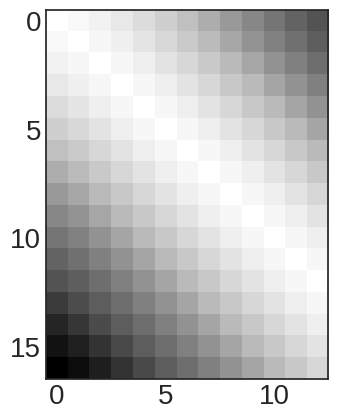

In [10]:
# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["2-Subjettiness"]


# Collect our observables in one dictionary
observables = {}
observables["2-Subjettiness"] = _2subjettiness

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)

# print(np.array(events)[0,1])



losses = shaper.pairwise_emds2(events[:17], events[:13], beta = 1, R = 1)
print(losses.shape)



/tmp/ipykernel_46208/2938025076.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(angles, angles, np.log10(losses), levels = 25)


TypeError: Length of x (180) must match number of columns in z (13)

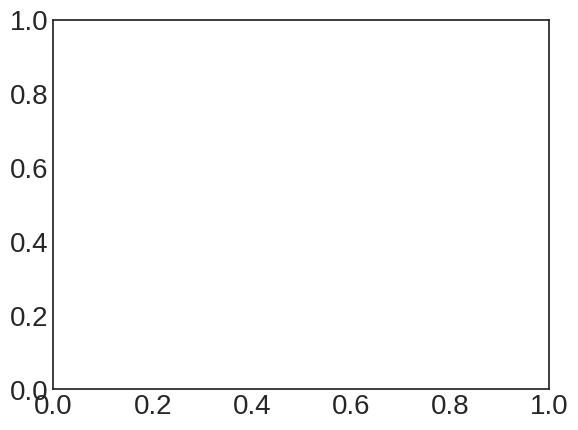

In [7]:
plt.contourf(angles, angles, np.log10(losses), levels = 25)
plt.colorbar()


In [ ]:
# sEMDs
from tqdm import tqdm


sEMDs = np.zeros_like(losses)
for (i,e1) in tqdm(enumerate(events)):
    for (j,e2) in enumerate(events):

        s1 = compute_spectral_representation(e1, type = "jet")
        s2 = compute_spectral_representation(e2, type = "jet")
        sEMDs[i,j] = (ds2(s1, s2))


In [ ]:
plt.contourf(angles, angles, np.log10(sEMDs), levels = 25)
plt.colorbar()

In [ ]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  


flat_emds = losses.flatten()
flat_semds = sEMDs.flatten()

plt.scatter(flat_emds, flat_semds, alpha = 0.1)


plt.legend(frameon = False)

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")